#  CNN + BiLSTM + Attention for Multi-Class URL Classification 


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
#  Load and preprocess dataset
#df = pd.read_csv('/home/user/ml_Mastery/NIDS/URL filtering/malicious_phish.csv')  # replace with your file
#######################################################33

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load and Clean
def load_and_clean(path):
    df1 = pd.read_csv(path)
    df1.columns = [col.lower().strip() for col in df1.columns]
    if 'label' in df1.columns:
        df1.rename(columns={'label': 'type'}, inplace=True)
    elif 'category' in df1.columns:
        df1.rename(columns={'category': 'type'}, inplace=True)
    elif 'class' in df1.columns:
        df1.rename(columns={'class': 'type'}, inplace=True)
    if 'url' not in df1.columns or 'type' not in df1.columns:
        print(f"❌ Missing 'url' or 'type' in {path} -> Skipped")
        return pd.DataFrame(columns=['url', 'type'])
    
    df1 = df1[['url', 'type']].dropna()
    df1['type'] = df1['type'].str.lower().str.strip()  # 🔥 normalize labels here
    return df1

# Load datasets
df = pd.concat([
    load_and_clean("/home/user/ml_Mastery/NIDS/URL filtering/malicious_phish.csv"),
    load_and_clean("/home/user/ml_Mastery/NIDS/URL filtering/Phishing URLs.csv"),
    load_and_clean("/home/user/ml_Mastery/NIDS/URL filtering/URL dataset.csv")
], ignore_index=True)

df = df.drop_duplicates().reset_index(drop=True)

le = LabelEncoder()
df['label'] = le.fit_transform(df['type'])

print("Encoded classes:", le.classes_)
print("Sample counts:\n", df['type'].value_counts())


#######################################################333
df = df[['url', 'type']].dropna().drop_duplicates()
#df = df.sample(n=100000, random_state=42).reset_index(drop=True)
df = df.reset_index(drop=True)
le = LabelEncoder()
df['label'] = le.fit_transform(df['type'])
print(le.classes_)

Encoded classes: ['benign' 'defacement' 'legitimate' 'malware' 'phishing']
Sample counts:
 type
benign        428080
legitimate    345738
phishing      252190
defacement     95308
malware        23645
Name: count, dtype: int64
['benign' 'defacement' 'legitimate' 'malware' 'phishing']


In [3]:
from sklearn.utils import resample

dfs = []
max_count = df['label'].value_counts().max()  # Use the largest class count (e.g., 'benign')

for label in df['label'].unique():
    subset = df[df['label'] == label]
    dfs.append(resample(subset, replace=True, n_samples=max_count, random_state=42))

df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset distribution:\n", df_balanced['label'].value_counts())

Balanced dataset distribution:
 label
4    428080
3    428080
2    428080
1    428080
0    428080
Name: count, dtype: int64


In [4]:
# Character-level encoding
all_chars = set(''.join(df_balanced['url']))
char2idx = {ch: idx+1 for idx, ch in enumerate(sorted(all_chars))}
char2idx['<PAD>'] = 0
vocab_size = len(char2idx)
max_len = 300

In [5]:
# Dataset and DataLoader
class URLDataset(Dataset):
    def __init__(self, urls, labels):
        self.urls = urls
        self.labels = labels

    def __len__(self): return len(self.urls)
    def __getitem__(self, idx):
        url = self.urls[idx][:max_len]
        encoded = [char2idx.get(ch, 0) for ch in url]
        padded = torch.tensor(encoded + [0]*(max_len - len(encoded)), dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return padded, label

#train_dataset = URLDataset(df['url'][:80000].tolist(), df['label'][:80000].tolist())
#val_dataset = URLDataset(df['url'][80000:].tolist(), df['label'][80000:].tolist())

train_dataset = URLDataset(df_balanced['url'][:220000].tolist(), df_balanced['label'][:220000].tolist())
val_dataset   = URLDataset(df_balanced['url'][220000:230000].tolist(), df_balanced['label'][220000:230000].tolist())

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # increase batch size if GPU has more memory
val_loader = DataLoader(val_dataset, batch_size=128)

# Deep CNN + BiLSTM + Attention + Dropout

class CNN_BiLSTM_MultiKernel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # CNN branches with kernel sizes 2, 3, 4
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, 128, kernel_size=k, padding=k//2) for k in [2, 3, 4]
        ])

        self.dropout_cnn = nn.Dropout(0.5)

        # BiLSTM after CNN
        self.lstm = nn.LSTM(128 * len(self.convs), hidden_dim, batch_first=True, bidirectional=True)

        self.attn_fc = nn.Linear(hidden_dim * 2, 1)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # (B, embed_dim, T)
    
        conv_outs = [F.relu(conv(x)) for conv in self.convs]  # list of (B, 128, T_i)
    
    # Find minimum length among outputs
        min_len = min([out.shape[2] for out in conv_outs])
    
    # Center crop to min_len
        conv_outs = [out[:, :, :min_len] for out in conv_outs]
    
        x = torch.cat(conv_outs, dim=1)  # (B, 128*3, min_len)
    
        x = self.dropout_cnn(x).permute(0, 2, 1)  # (B, min_len, 128*3)
        lstm_out, _ = self.lstm(x)  # (B, T, 2*hidden_dim)

        attn_weights = torch.softmax(self.attn_fc(lstm_out), dim=1)  # (B, T, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, 2*hidden_dim)

        return self.classifier(context)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiKernelCNN_BiLSTM_Attention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, kernel_sizes=[3,5,7], num_filters=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # CNN blocks with multiple kernel sizes
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2)
            ) for k in kernel_sizes
        ])

        # BiLSTM input size = num_filters * len(kernel_sizes)
        self.bilstm = nn.LSTM(input_size=num_filters * len(kernel_sizes),
                              hidden_size=hidden_dim,
                              num_layers=1,
                              batch_first=True,
                              bidirectional=True)

        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        self.classifier = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        # x: [batch, seq_len]
        embed = self.embedding(x)               # [batch, seq_len, embed_dim]
        embed = embed.permute(0, 2, 1)          # [batch, embed_dim, seq_len]

        conv_outputs = [conv(embed) for conv in self.convs]
        pooled = torch.cat(conv_outputs, dim=1) # [batch, total_filters, seq_len/2]
        pooled = pooled.permute(0, 2, 1)        # [batch, seq_len/2, total_filters]

        lstm_out, _ = self.bilstm(pooled)       # [batch, seq_len/2, 2*hidden_dim]
        attn_weights = self.attention(lstm_out) # [batch, seq_len/2, 1]
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, 2*hidden_dim]

        out = self.classifier(attn_applied)     # [batch, num_classes]
        return out
    
    # Add this method to your model
    def extract_features(self, x):
        embed = self.embedding(x).permute(0, 2, 1)
        conv_outputs = [conv(embed) for conv in self.convs]
        pooled = torch.cat(conv_outputs, dim=1).permute(0, 2, 1)
        lstm_out, _ = self.bilstm(pooled)
        attn_weights = self.attention(lstm_out)
        attn_applied = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, 2*hidden_dim]
        return attn_applied

100%|██████████| 860/860 [00:28<00:00, 29.92it/s]


Epoch 1 | Train Loss: 217.2647 | Val F1: 0.9596


100%|██████████| 860/860 [00:28<00:00, 30.45it/s]


Epoch 2 | Train Loss: 96.7057 | Val F1: 0.9658


100%|██████████| 860/860 [00:27<00:00, 30.72it/s]


Epoch 3 | Train Loss: 74.1191 | Val F1: 0.9749


100%|██████████| 860/860 [00:28<00:00, 30.51it/s]


Epoch 4 | Train Loss: 60.7979 | Val F1: 0.9749


100%|██████████| 860/860 [00:28<00:00, 30.58it/s]


Epoch 5 | Train Loss: 50.1622 | Val F1: 0.9795


100%|██████████| 860/860 [00:28<00:00, 30.26it/s]


Epoch 6 | Train Loss: 43.0384 | Val F1: 0.9800


100%|██████████| 860/860 [00:28<00:00, 30.52it/s]


Epoch 7 | Train Loss: 37.5097 | Val F1: 0.9803


100%|██████████| 860/860 [00:28<00:00, 30.61it/s]


Epoch 8 | Train Loss: 31.6713 | Val F1: 0.9830


100%|██████████| 860/860 [00:28<00:00, 30.62it/s]


Epoch 9 | Train Loss: 25.8548 | Val F1: 0.9817


100%|██████████| 860/860 [00:28<00:00, 30.46it/s]


Epoch 10 | Train Loss: 23.1130 | Val F1: 0.9832


100%|██████████| 860/860 [00:28<00:00, 30.28it/s]


Epoch 11 | Train Loss: 17.9498 | Val F1: 0.9818


100%|██████████| 860/860 [00:28<00:00, 30.41it/s]


Epoch 12 | Train Loss: 16.5197 | Val F1: 0.9847


100%|██████████| 860/860 [00:27<00:00, 30.76it/s]


Epoch 13 | Train Loss: 13.5620 | Val F1: 0.9843


100%|██████████| 860/860 [00:28<00:00, 30.56it/s]


Epoch 14 | Train Loss: 11.5927 | Val F1: 0.9839


100%|██████████| 860/860 [00:28<00:00, 30.40it/s]


Epoch 15 | Train Loss: 10.4047 | Val F1: 0.9846


100%|██████████| 860/860 [00:28<00:00, 30.57it/s]


Epoch 16 | Train Loss: 8.3108 | Val F1: 0.9842


100%|██████████| 860/860 [00:28<00:00, 30.54it/s]


Epoch 17 | Train Loss: 7.0294 | Val F1: 0.9850


100%|██████████| 860/860 [00:28<00:00, 30.39it/s]


Epoch 18 | Train Loss: 7.5764 | Val F1: 0.9842


100%|██████████| 860/860 [00:28<00:00, 30.25it/s]


Epoch 19 | Train Loss: 5.6224 | Val F1: 0.9846


100%|██████████| 860/860 [00:28<00:00, 30.28it/s]


Epoch 20 | Train Loss: 5.8247 | Val F1: 0.9839


100%|██████████| 860/860 [00:28<00:00, 30.40it/s]


Epoch 21 | Train Loss: 5.6913 | Val F1: 0.9866


100%|██████████| 860/860 [00:28<00:00, 30.37it/s]


Epoch 22 | Train Loss: 4.1332 | Val F1: 0.9865


100%|██████████| 860/860 [00:28<00:00, 30.17it/s]


Epoch 23 | Train Loss: 3.7709 | Val F1: 0.9870


100%|██████████| 860/860 [00:28<00:00, 30.34it/s]


Epoch 24 | Train Loss: 3.8629 | Val F1: 0.9854


100%|██████████| 860/860 [00:28<00:00, 30.54it/s]


Epoch 25 | Train Loss: 3.9967 | Val F1: 0.9866


100%|██████████| 860/860 [00:28<00:00, 30.44it/s]


Epoch 26 | Train Loss: 4.0022 | Val F1: 0.9834


100%|██████████| 860/860 [00:27<00:00, 30.92it/s]


Epoch 27 | Train Loss: 2.8071 | Val F1: 0.9835


100%|██████████| 860/860 [00:27<00:00, 30.75it/s]


Epoch 28 | Train Loss: 4.1442 | Val F1: 0.9874


100%|██████████| 860/860 [00:28<00:00, 30.64it/s]


Epoch 29 | Train Loss: 1.8831 | Val F1: 0.9855


100%|██████████| 860/860 [00:27<00:00, 30.80it/s]


Epoch 30 | Train Loss: 1.2662 | Val F1: 0.9847


100%|██████████| 860/860 [00:27<00:00, 30.76it/s]


Epoch 31 | Train Loss: 4.4241 | Val F1: 0.9871


100%|██████████| 860/860 [00:27<00:00, 30.83it/s]


Epoch 32 | Train Loss: 2.5969 | Val F1: 0.9868


100%|██████████| 860/860 [00:27<00:00, 30.76it/s]


Epoch 33 | Train Loss: 2.4153 | Val F1: 0.9862


100%|██████████| 860/860 [00:28<00:00, 30.51it/s]


Epoch 34 | Train Loss: 2.5222 | Val F1: 0.9869


100%|██████████| 860/860 [00:28<00:00, 30.45it/s]


Epoch 35 | Train Loss: 2.3621 | Val F1: 0.9863


100%|██████████| 860/860 [00:28<00:00, 30.44it/s]


Epoch 36 | Train Loss: 2.2551 | Val F1: 0.9848


100%|██████████| 860/860 [00:28<00:00, 30.35it/s]


Epoch 37 | Train Loss: 2.0780 | Val F1: 0.9853


100%|██████████| 860/860 [00:28<00:00, 30.57it/s]


Epoch 38 | Train Loss: 2.2057 | Val F1: 0.9855


100%|██████████| 860/860 [00:28<00:00, 30.26it/s]


Epoch 39 | Train Loss: 2.3162 | Val F1: 0.9855


100%|██████████| 860/860 [00:28<00:00, 30.19it/s]


Epoch 40 | Train Loss: 1.8068 | Val F1: 0.9837
              precision    recall  f1-score   support

      benign       0.98      0.97      0.98      2040
  defacement       0.99      1.00      0.99      1964
  legitimate       1.00      1.00      1.00      1919
     malware       0.99      0.99      0.99      2084
    phishing       0.96      0.96      0.96      1993

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



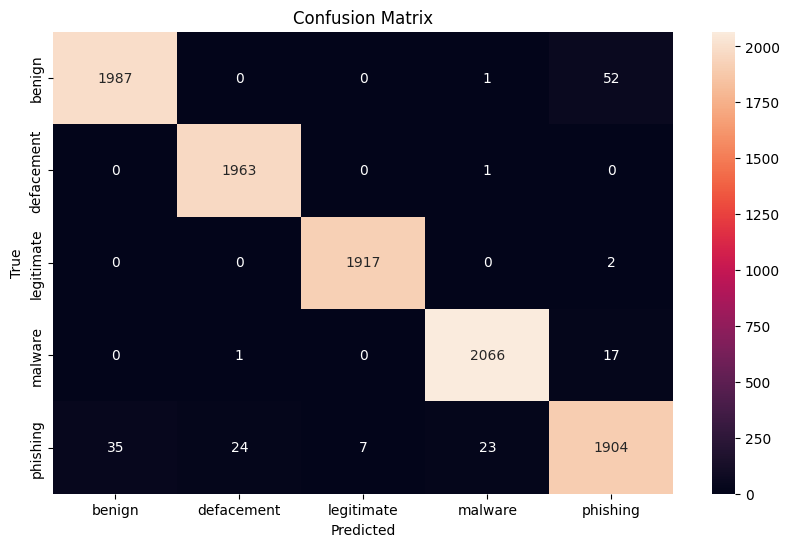

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
# Train & Evaluate
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiKernelCNN_BiLSTM_Attention(vocab_size, embed_dim=256, hidden_dim=512, num_classes=len(le.classes_)).to(device)
# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)  # reduced LR for stability
criterion = nn.CrossEntropyLoss()
# Track losses and F1
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(40):
    model.train()
    total_loss = 0
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

    # Validation
    features_list = []
    labels_list = []
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            embeddings = model.extract_features(x)
            features_list.append(embeddings.cpu())
            labels_list.append(y.cpu())
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(y.numpy())
    X_features = torch.cat(features_list).numpy()
    y_labels = torch.cat(labels_list).numpy()
    f1 = f1_score(val_labels, val_preds, average='weighted')
    val_f1s.append(f1)
    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val F1: {f1:.4f}")


# Explicit label index list
label_ids = list(range(len(le.classes_)))
# Final evaluation
# Classification Report with fixed labels
print(classification_report(
    val_labels,
    val_preds,
    labels=label_ids,
    target_names=le.classes_,
    zero_division=0  # avoid divide-by-zero warnings
))
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

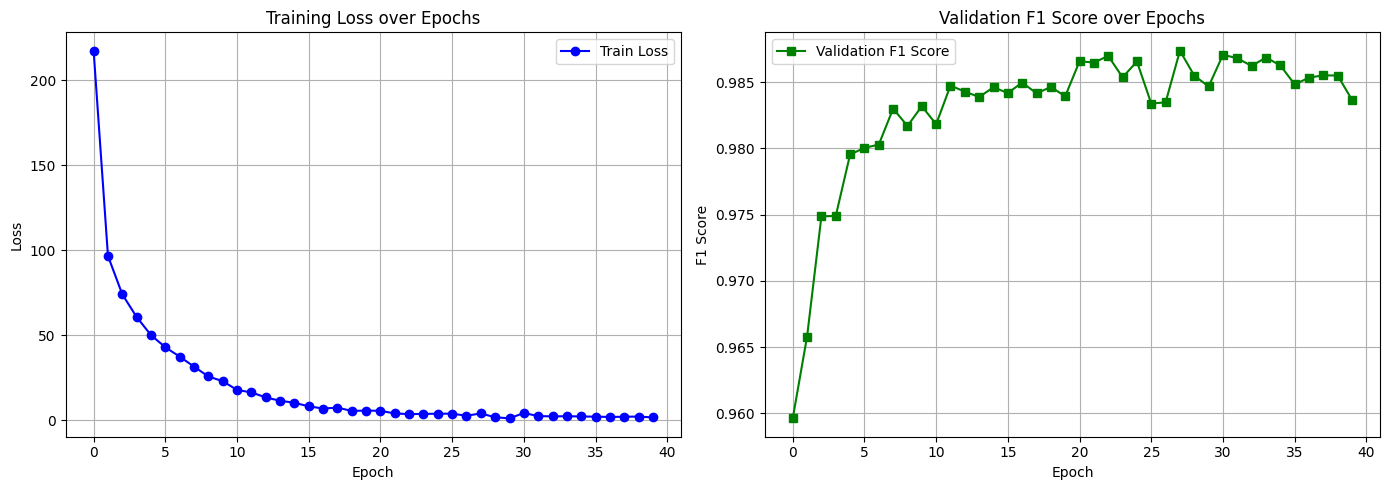

In [8]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o', label='Train Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1s, marker='s', label='Validation F1 Score', color='green')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Inference and Export
def predict_urls(model, urls):
    model.eval()
    preds = []
    with torch.no_grad():
        for url in urls:
            encoded = [char2idx.get(c, 0) for c in url[:max_len]]
            padded = torch.tensor(encoded + [0]*(max_len - len(encoded)), dtype=torch.long).unsqueeze(0).to(device)
            logits = model(padded)
            pred = torch.argmax(logits, dim=1).item()
            preds.append(le.inverse_transform([pred])[0])
    return preds

# Example
new_urls = [
    'http://paypal.com.verify.login.session-redirect.com',
    'https://github.com/openai/gpt-4',
    'http://198.51.100.23/payments/reset-password',
    'https://www.google.com/',
    'https://www.cocomelon.com/'

]
predicted_labels = predict_urls(model, new_urls)
pd.DataFrame({'url': new_urls, 'predicted_label': predicted_labels}).to_csv('url_predictions.csv', index=False)
pd.DataFrame({'url': new_urls, 'predicted_label': predicted_labels})

,url,predicted_label
0,http://paypal.com.verify.login.session-redirec...,phishing
1,https://github.com/openai/gpt-4,phishing
2,http://198.51.100.23/payments/reset-password,phishing
3,https://www.google.com/,legitimate
4,https://www.cocomelon.com/,legitimate


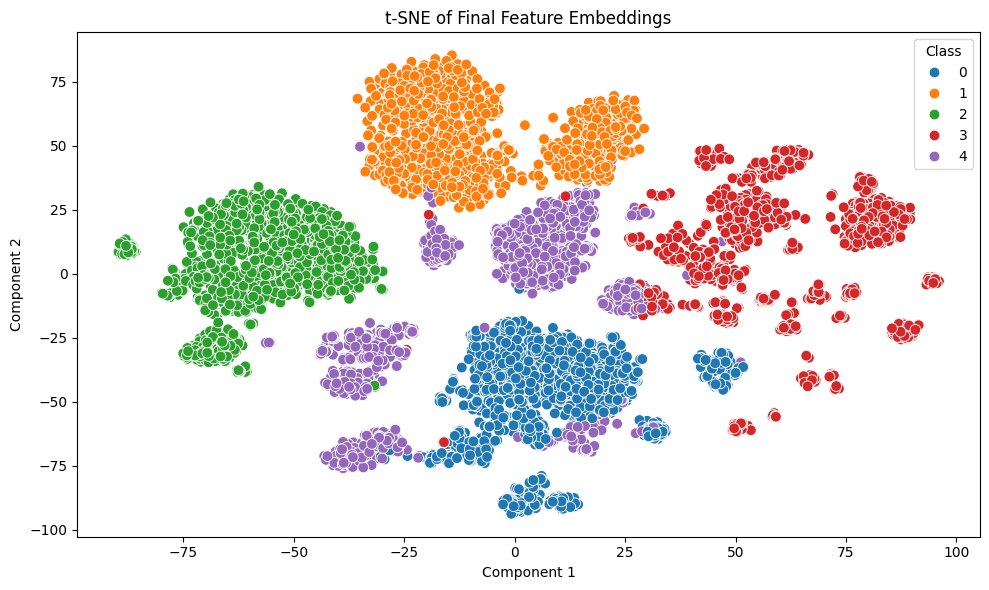

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# t-SNE (or replace with UMAP)
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_features)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_labels, palette='tab10', s=60)
plt.title("t-SNE of Final Feature Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

What This t-SNE Plot Shows:
Clear clustering of all five classes (0 to 4), suggesting the model learned strong, separable latent representations.

Minimal overlap between clusters → indicates high inter-class discrimination.

A few outlier points or mixed regions suggest:

Class overlap in raw features (e.g., phishing vs malware)

Potential mislabeled data

Samples near decision boundaries

In [97]:
from umap import UMAP

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X_features)

2025-05-11 02:31:40.151198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 02:31:40.186382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 02:31:40.197354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 02:31:40.273048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 02:31:41.0

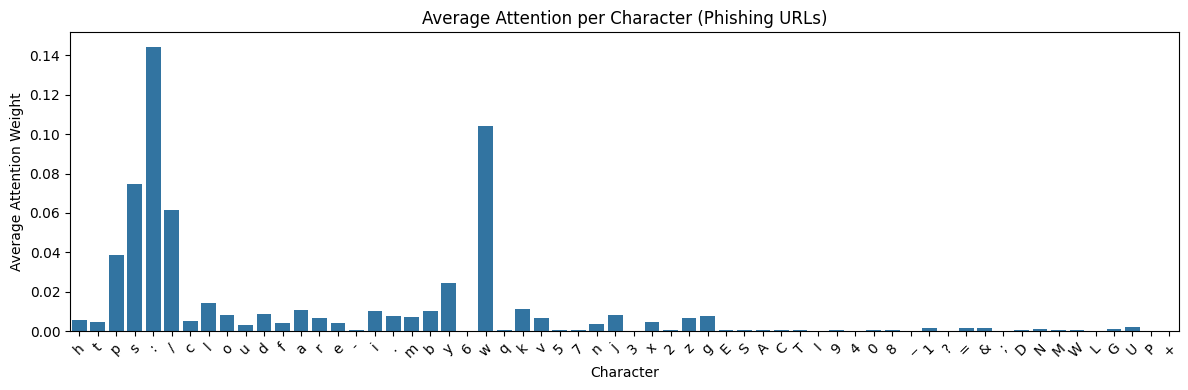

In [20]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define get_attention_weights
def get_attention_weights(model, url, char2idx, max_len, device):
    """
    Extracts attention weights for a given URL using a trained MultiKernelCNN_BiLSTM_Attention model.
    """
    model.eval()
    encoded = [char2idx.get(c, 0) for c in url[:max_len]]
    padded = torch.tensor(encoded + [0] * (max_len - len(encoded)), dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.embedding(padded).permute(0, 2, 1)
        conv_outputs = [conv(emb) for conv in model.convs]
        pooled = torch.cat(conv_outputs, dim=1).permute(0, 2, 1)
        lstm_out, _ = model.bilstm(pooled)
        attn_weights = model.attention(lstm_out).squeeze().cpu().numpy()
    
    return attn_weights[:len(url)]

# Step 2: Load sample phishing URLs (label index 4 = phishing)
phishing_class_index = 4
sample_urls = df[df['label'] == phishing_class_index]['url'].sample(n=min(100, len(df[df['label'] == phishing_class_index])), random_state=42).tolist()

# Step 3: Aggregate attention weights
char_attn = defaultdict(list)

for url in sample_urls:
    try:
        weights = get_attention_weights(model, url, char2idx, max_len, device)
        for i, c in enumerate(url[:len(weights)]):
            char_attn[c].append(weights[i])
    except Exception as e:
        print(f"⚠️ Skipped a URL due to error: {e}")
        continue

# Step 4: Compute average attention per character
avg_char_attention = {
    c: sum(v) / len(v)
    for c, v in char_attn.items()
    if len(v) > 5  # Ignore characters seen in <5 URLs
}

# Step 5: Plot
plt.figure(figsize=(12, 4))
sns.barplot(x=list(avg_char_attention.keys()), y=list(avg_char_attention.values()))
plt.title("Average Attention per Character (Phishing URLs)")
plt.xlabel("Character")
plt.ylabel("Average Attention Weight")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

   


In [21]:
# Attention Visualization
def visualize_attention(model, sample_urls, char2idx, max_len=100, device='cpu'):
    """
    Visualizes attention weights over input URLs for MultiKernelCNN_BiLSTM_Attention model.
    """
    model.eval()
    
    for url in sample_urls:
        encoded = [char2idx.get(c, 0) for c in url[:max_len]]
        padded = torch.tensor(encoded + [0]*(max_len - len(encoded)), dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            emb = model.embedding(padded)                     # [1, seq_len, embed_dim]
            emb = emb.permute(0, 2, 1)                        # [1, embed_dim, seq_len]
            
            # Apply all conv layers and concatenate
            conv_outputs = [conv(emb) for conv in model.convs]  # Each: [1, filters, seq_len/2]
            pooled = torch.cat(conv_outputs, dim=1)           # [1, total_filters, seq_len/2]
            pooled = pooled.permute(0, 2, 1)                  # [1, seq_len/2, total_filters]

            lstm_out, _ = model.bilstm(pooled)                # [1, seq_len/2, 2*hidden_dim]
            attn_weights = model.attention(lstm_out)          # [1, seq_len/2, 1]
            attn_weights = attn_weights.squeeze().cpu().numpy()

        # Display bar chart over tokens
        display_len = min(len(attn_weights), len(url))
        plt.figure(figsize=(max(6, display_len // 2), 2))
        plt.bar(range(display_len), attn_weights[:display_len])
        plt.xticks(range(display_len), list(url[:display_len]), rotation='vertical', fontsize=10)
        plt.title(f"Attention on: {url}")
        plt.tight_layout()
        plt.show()


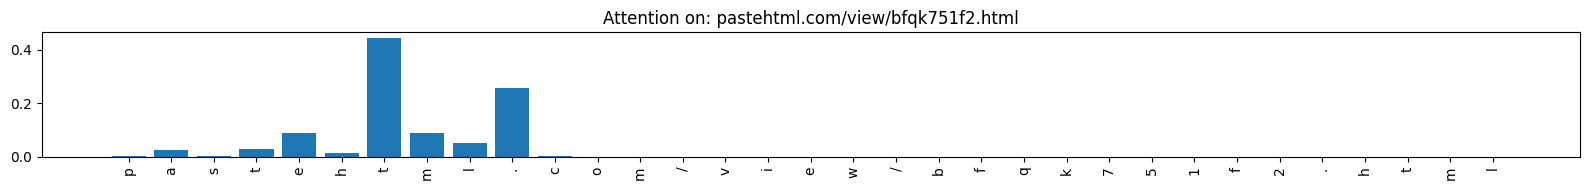

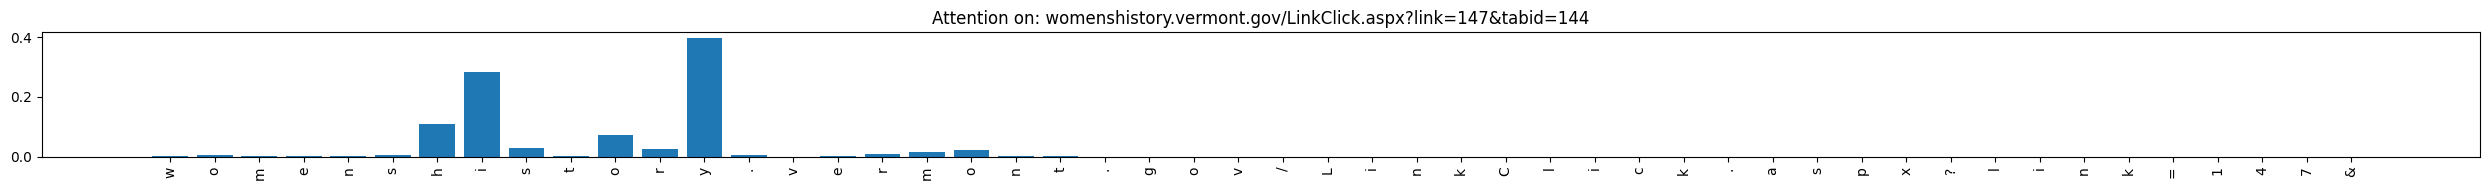

In [100]:
sample_urls = df['url'].sample(2).tolist()
visualize_attention(model, sample_urls, char2idx=char2idx, max_len=100, device=device)
